# Contents:



*   [About Data](https://www.kaggle.com/datasets/arkhoshghalb/twitter-sentiment-analysis-hatred-speech?datasetId=100982&sortBy=voteCount)
*   [Feature Extraction and EDA](#eda)
*   [Preprocessing](#prep)
*   [Vectorization](#vec)
*   [Dealing with Imblanced Data](#imb)
*   [Data Splitting](#split)
*   [Modeling](#model)
  * [Naive Bayes](#naive)
  * [RandomForest](#rf)


# Libraries:

In [136]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import joblib


import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk import WordNetLemmatizer
from wordcloud import WordCloud


import re
import string

from sklearn.base import TransformerMixin
from sklearn.metrics import confusion_matrix, classification_report, \
                                       f1_score, accuracy_score, \
                                        plot_confusion_matrix, roc_auc_score, roc_curve,auc

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as PL


import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=DeprecationWarning)

# configuration
plt.style.use('seaborn-pastel')
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = 8, 6

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

# Data:

In [3]:
%cd /content/drive/MyDrive/TwitterSentiment/

/content/drive/MyDrive/TwitterSentiment


In [57]:
df = pd.read_csv('train.csv')
df.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [5]:
df.shape

(31962, 3)

In [6]:
df.isna().sum()

id       0
label    0
tweet    0
dtype: int64

In [7]:
df.duplicated().sum()

0

<a name = 'eda'></a>
# Feature Extraction

In [26]:
# first make copy of data:
dfc = df.copy()

In [27]:
dfc.drop(columns = ['id'], inplace = True)

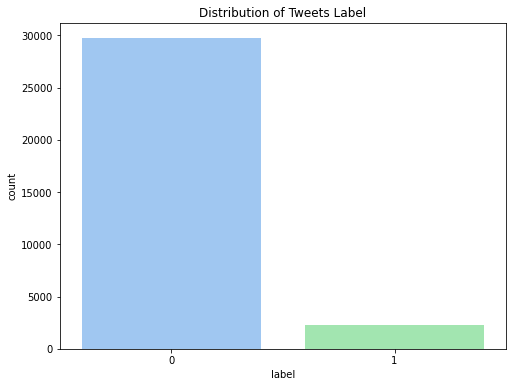

In [14]:
sns.countplot(dfc.label)
plt.title("Distribution of Tweets Label")
plt.savefig("Dist_Label.png")
plt.show();

In [15]:
dfc.label.value_counts(normalize = True)

0    0.929854
1    0.070146
Name: label, dtype: float64

 **The data is highly imbalanced with about 93% of tweets being non-negative.**

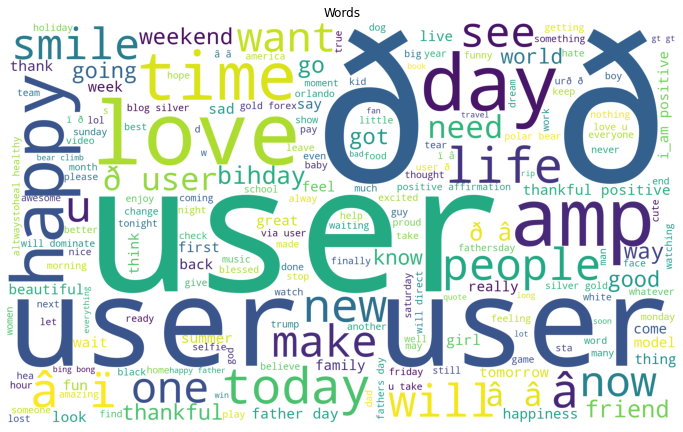

In [21]:
plt.figure(figsize= (12, 10))
wordcloud = WordCloud(background_color = 'white', height = 1200, width = 2000).generate(' '.join(dfc['tweet']))
plt.axis('off')
plt.title("Words")
wordcloud.to_file('wordscloud.png')
plt.imshow(wordcloud);

**The tweets contains words ( _user_ and  _@user_ ), that is not part of tweet text, so we deleting them.**

In [28]:
# delete user and @ user 
dfc['tweet']  = dfc.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in set(['user', '@user'])))
# check
dfc.head()

,label,tweet
0,0,when a father is dysfunctional and is so selfi...
1,0,thanks for #lyft credit i can't use cause they...
2,0,bihday your majesty
3,0,#model i love u take with u all the time in ur...
4,0,factsguide: society now #motivation


In [29]:
# count the number of words per tweet:
dfc['words_count'] = dfc.tweet.apply(lambda x: len(x.split()))
dfc.head()

,label,tweet,words_count
0,0,when a father is dysfunctional and is so selfi...,17
1,0,thanks for #lyft credit i can't use cause they...,17
2,0,bihday your majesty,3
3,0,#model i love u take with u all the time in ur...,14
4,0,factsguide: society now #motivation,4


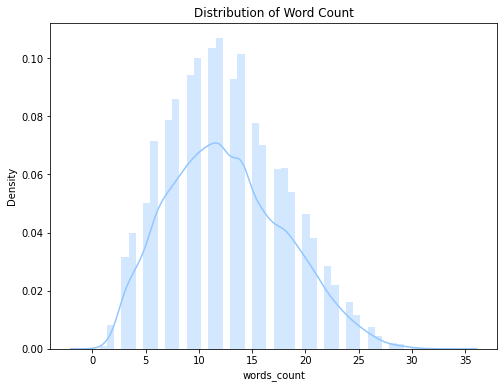

In [31]:
sns.distplot(dfc.words_count)
plt.title('Distribution of Word Count')
plt.savefig("wordcount_dist.png")
plt.show()

In [32]:
print(f"The average length of tweets is about : {dfc.words_count.mean():.0f} words")

The average length of tweets is about : 13 words


In [33]:
mask = dfc.label == 1
print(f"The average length of negative tweets is about : {dfc[mask].words_count.mean():.0f} words")
print(f"The average length of non-negative tweets is about : {dfc[~mask].words_count.mean():.0f} words")

The average length of negative tweets is about : 13 words
The average length of non-negative tweets is about : 13 words


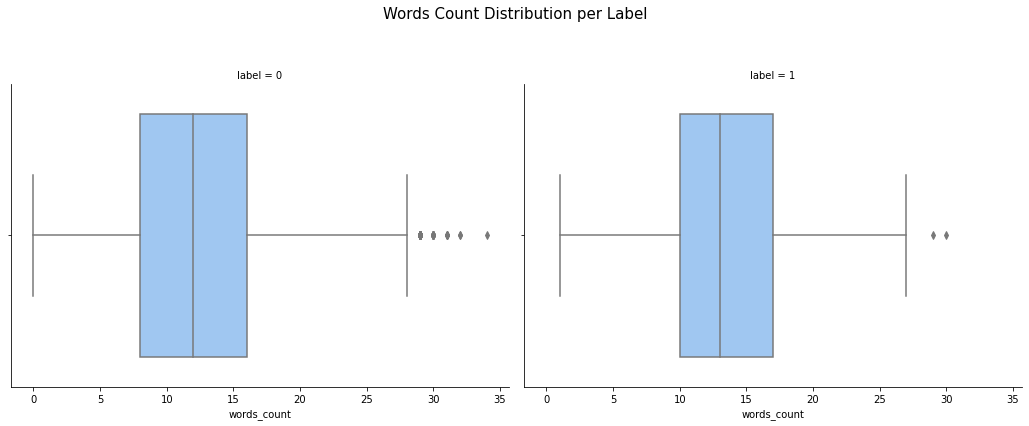

In [34]:
g = sns.FacetGrid(data = dfc, col = 'label', height= 6, aspect= 1.2)
g.map(sns.boxplot, 'words_count')
g.fig.subplots_adjust(top=0.8)
g.fig.suptitle('Words Count Distribution per Label', fontsize = 15)
plt.savefig('wordscount_perlabel.png')
plt.show()

In [35]:
# count the number of hashtags (#) in each tweet
dfc['hashtags_count'] = dfc['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
# check
dfc.head()

,label,tweet,words_count,hashtags_count
0,0,when a father is dysfunctional and is so selfi...,17,1
1,0,thanks for #lyft credit i can't use cause they...,17,3
2,0,bihday your majesty,3,0
3,0,#model i love u take with u all the time in ur...,14,1
4,0,factsguide: society now #motivation,4,1


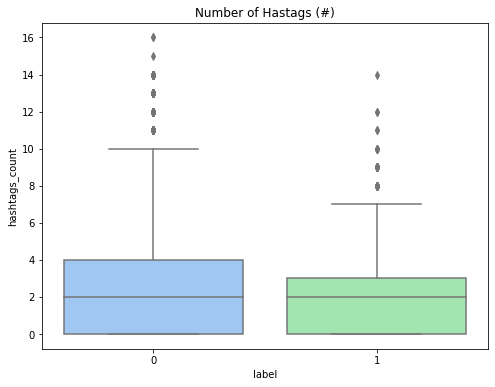

In [36]:
sns.boxplot(data = dfc, y ='hashtags_count', x = 'label')
plt.title("Number of Hastags (#)")
plt.savefig('hastags.png')
plt.show()

In [40]:
print(f"The average number of hashtags in negative tweets is about : {dfc[mask].hashtags_count.mean():.0f} hashtags")
print(f"The average number of hashtags in non-negative tweets is about : {dfc[~mask].hashtags_count.mean():.0f} hashtags")

The average number of hashtags in negative tweets is about : 2 hashtags
The average number of hashtags in non-negative tweets is about : 2 hashtags


In [39]:
# number of stop words
stop_words = stopwords.words('english')
dfc['stopwords_count'] = dfc['tweet'].apply(lambda x: len([x for x in x.split() if x in set(stop_words)]))

In [43]:
print(f"The average number of stopwords in negative tweets is about : {dfc[mask].stopwords_count.mean():.0f} words")
print(f"The average number of stopwords in non-negative tweets is about : {dfc[~mask].stopwords_count.mean():.0f} words")

The average number of stopwords in negative tweets is about : 4 words
The average number of stopwords in non-negative tweets is about : 4 words


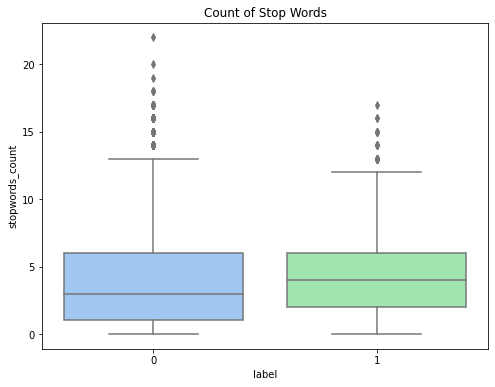

In [42]:
sns.boxplot(data = dfc, y ='stopwords_count', x = 'label')
plt.title("Count of Stop Words")
plt.savefig('stop_count.png')
plt.show()

<a name = 'prep'></a>
# Cleaning and Preprocessing:

In [44]:
# removing markup and hyperlinks:
def clean(raw):
    result = re.sub("<[a][^>]*>(.+?)</[a]>", 'Link.', raw)
    result = re.sub('&gt;', "", result) # greater than sign
    result = re.sub('&#x27;', "'", result) # apostrophe
    result = re.sub('&#x2F;', ' ', result)
    result = re.sub('<p>', ' ', result) # paragraph tag
    result = re.sub('<i>', ' ', result) #italics tag
    result = re.sub('</i>', '', result) 
    result = re.sub('&#62;', '', result)
    result = re.sub("\n", '', result) # newline 
    return result 

In [45]:
# removing emojies
def deEmojify(x):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'', x)

In [46]:
# removing punctuations:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    text = re.sub(r"[^a-zA-Z0-9?!.,]+", ' ', text)
    return text

In [47]:
# change to lower case:
def lower_case(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x.lower() for x in x.split()))

In [48]:
# remove stop words
def stop_words_remove(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join(x for x in x.split() if x not in set(stop_words)))

In [49]:
# lemmatization
def lemmatize(df):
    df['tweet'] = df['tweet'].apply(lambda x: " ".join([Word.lemmatize(word) for word in x.split()]))

In [50]:
Word = WordNetLemmatizer()

In [58]:
def preprocessing(df, stop_words = stop_words, Word = Word):
  dfc = df.copy()
  dfc.drop(columns = ['id'], inplace  = True)
  dfc['tweet']  = dfc.tweet.apply(lambda x: " ".join(x for x in x.split() if x not in set(['user', '@user'])))
  dfc['words_count'] = dfc.tweet.apply(lambda x: len(x.split()))
  dfc['hashtags_count'] = dfc['tweet'].apply(lambda x: len([x for x in x.split() if x.startswith('#')]))
  dfc['stopwords_count'] = dfc['tweet'].apply(lambda x: len([x for x in x.split() if x in set(stop_words)]))
  dfc['tweet'] = dfc['tweet'].apply(clean)
  dfc['tweet'] = dfc['tweet'].apply(deEmojify)
  dfc['tweet'] = dfc['tweet'].apply(lambda x: remove_punct(x))
  lower_case(dfc)
  stop_words_remove(dfc)
  lemmatize(dfc)
  return dfc



In [59]:
prep_df = preprocessing(df)
prep_df.head()

,label,tweet,words_count,hashtags_count,stopwords_count
0,0,father dysfunctional selfish drag kid dysfunct...,17,1,10
1,0,thanks lyft credit cant use cause dont offer w...,17,3,5
2,0,bihday majesty,3,0,1
3,0,model love u take u time ur,14,1,5
4,0,factsguide society motivation,4,1,1


In [61]:
prep_df.to_csv('prep_data.csv', index = False)

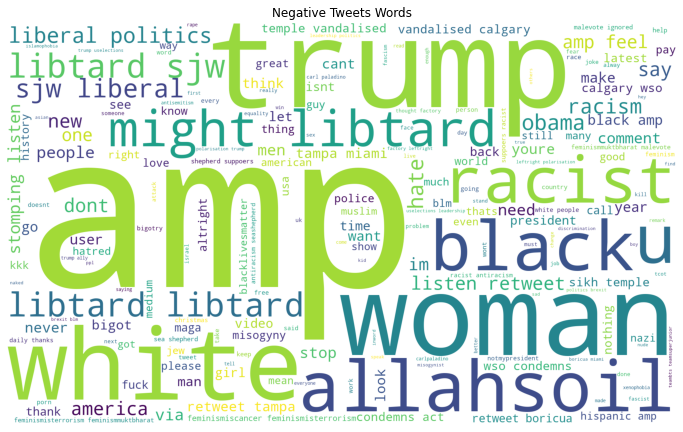

In [64]:
plt.figure(figsize= (12, 10))
wordcloud = WordCloud(background_color = 'white', height = 1200, width = 2000).generate(' '.join(prep_df[mask]['tweet']))
plt.axis('off')
plt.title("Negative Tweets Words")
wordcloud.to_file('negcloud_clean.png')
plt.imshow(wordcloud);

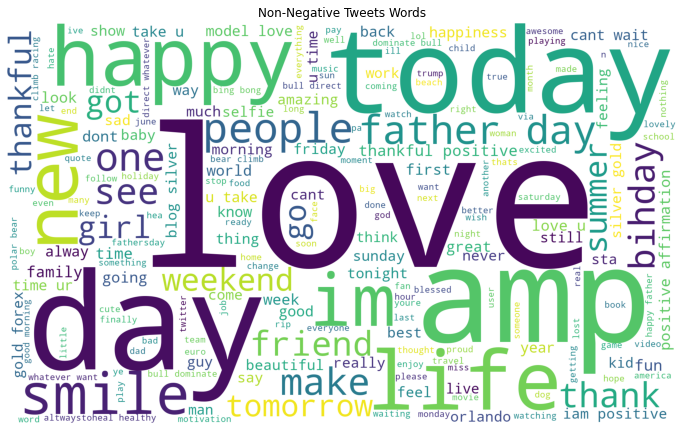

In [65]:
plt.figure(figsize= (12, 10))
wordcloud = WordCloud(background_color = 'white', height = 1200, width = 2000).generate(' '.join(prep_df[~mask]['tweet']))
plt.axis('off')
plt.title("Non-Negative Tweets Words")
wordcloud.to_file('nonnegcloud_clean.png')
plt.imshow(wordcloud);

<a name ='vec'></a>
# Vectorizing Tweet Text:

In [108]:
X = prep_df.drop(columns = ['label'])
y = prep_df.label

In [109]:
vector = CountVectorizer(stop_words= "english",max_features=3000, ngram_range = (1,2))

In [110]:
def vectorizing_tweet(X, vector= vector):
  trans = vector.fit(X['tweet']) 
  x = trans.transform(X['tweet'])
  X = X.drop('tweet',axis = 'columns')
  X = pd.concat([X.reset_index(drop = True),pd.DataFrame(x.todense()).reset_index(drop = True)],axis = 'columns')
  #X = X.fillna(0)
  return X

In [111]:
X = vectorizing_tweet(X)
X.head()

,words_count,hashtags_count,stopwords_count,0,1,2,3,4,5,6,...,2990,2991,2992,2993,2994,2995,2996,2997,2998,2999
0,17,1,10,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,17,3,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,14,1,5,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


<a name ='imb'></a>

# Dealing with Imbalanced Data:

In [112]:
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)

steps = [('over',over),('under', under)]
pipeline = PL(steps=steps)

X, y = pipeline.fit_resample(X, y)

<a name ='split'></a>

# Splitting Data:

In [113]:
X_train, X_test, y_train, y_test = train_test_split(X, y,random_state = 40,
                                                   test_size = 0.20,stratify=y)

<a name ='model'></a>

# Modeling:

In [117]:
def print_score(clf, X_train, y_train, X_test, y_test, train=True):
    if train:
        pred = clf.predict(X_train)
        clf_report = pd.DataFrame(classification_report(y_train, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(y_train, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_train,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_train, pred)}\n")        
    elif train==False:
        pred = clf.predict(X_test)
        clf_report = pd.DataFrame(classification_report(y_test, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"ROC-AUC score: \n {roc_auc_score(y_test,pred)}\n")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")


In [114]:
tfidf = TfidfTransformer()

<a name ='naive'></a>

## Naive Bayes Classifier:

In [120]:
naive_bayes = GaussianNB()

In [130]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

pipeline1 = Pipeline([
    ('tfidf', tfidf),
    ('to_dense', DenseTransformer()),
    ('model', naive_bayes)
    ])
naive_model = pipeline1.fit(X_train,y_train)
preds1 = naive_model.predict(X_test)

In [131]:
print_score(pipeline1, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 85.58%
_______________________________________________
ROC-AUC score: 
 0.8914883190425813

_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999129     0.698360  0.855771      0.848745      0.898876
recall         0.784344     0.998633  0.855771      0.891488      0.855771
f1-score       0.878803     0.821931  0.855771      0.850367      0.859846
support    19021.000000  9510.000000  0.855771  28531.000000  28531.000000
_______________________________________________
Confusion Matrix: 
 [[14919  4102]
 [   13  9497]]



In [132]:
print_score(pipeline1, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 83.99%
_______________________________________________
ROC-AUC score: 
 0.8700357023150347

_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.975270     0.685474  0.839899     0.830372      0.878658
recall        0.779600     0.960471  0.839899     0.870036      0.839899
f1-score      0.866526     0.800000  0.839899     0.833263      0.844348
support    4755.000000  2378.000000  0.839899  7133.000000   7133.000000
_______________________________________________
Confusion Matrix: 
 [[3707 1048]
 [  94 2284]]



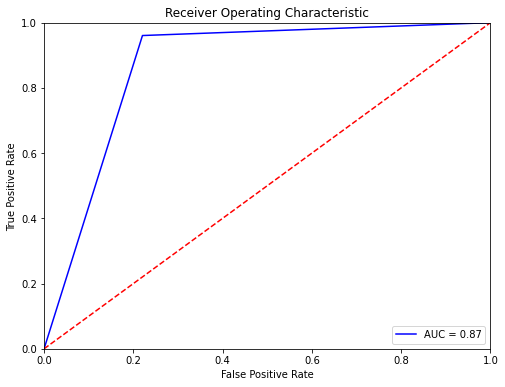

In [133]:
fpr, tpr, threshold = roc_curve(y_test, preds1)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

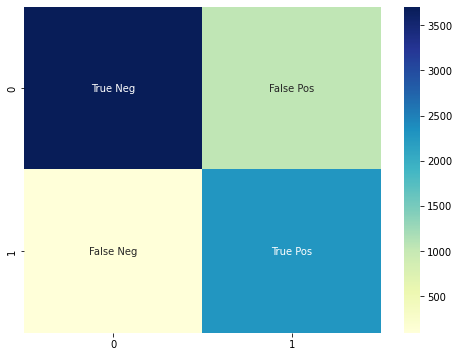

In [134]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test, preds1) ,annot = labels,fmt='',cmap = 'YlGnBu');

In [137]:
joblib.dump(naive_model, 'naive_pipeline.pkl')

['naive_pipeline.pkl']

<a name ='rf'></a>

## Random Forest Classifier:

In [140]:
rf = RandomForestClassifier()
pipeline2 = Pipeline([
    ('tfidf', tfidf),
    ('model', rf),
    ])
rf_model = pipeline2.fit(X_train,y_train)
preds2 = rf_model.predict(X_test)

In [141]:
print_score(pipeline2, X_train, y_train, X_test, y_test, train=True)

Train Result:
Accuracy Score: 99.07%
_______________________________________________
ROC-AUC score: 
 0.9928236990373859

_______________________________________________
CLASSIFICATION REPORT:
                      0            1  accuracy     macro avg  weighted avg
precision      0.999574     0.973665  0.990712      0.986620      0.990938
recall         0.986489     0.999159  0.990712      0.992824      0.990712
f1-score       0.992988     0.986247  0.990712      0.989618      0.990741
support    19021.000000  9510.000000  0.990712  28531.000000  28531.000000
_______________________________________________
Confusion Matrix: 
 [[18764   257]
 [    8  9502]]



In [142]:
print_score(pipeline2, X_train, y_train, X_test, y_test, train=False)

Test Result:
Accuracy Score: 95.36%
_______________________________________________
ROC-AUC score: 
 0.9438575568720987

_______________________________________________
CLASSIFICATION REPORT:
                     0            1  accuracy    macro avg  weighted avg
precision     0.957971     0.944420  0.953596     0.951196      0.953453
recall        0.973081     0.914634  0.953596     0.943858      0.953596
f1-score      0.965467     0.929289  0.953596     0.947378      0.953406
support    4755.000000  2378.000000  0.953596  7133.000000   7133.000000
_______________________________________________
Confusion Matrix: 
 [[4627  128]
 [ 203 2175]]



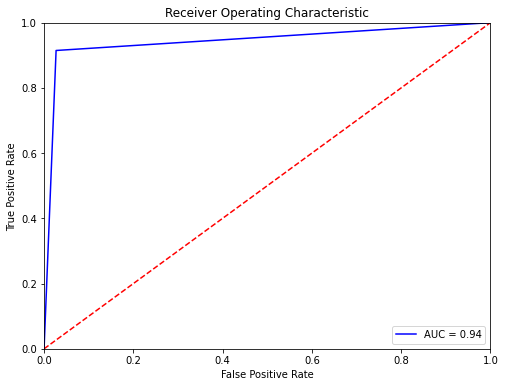

In [143]:
fpr, tpr, threshold = roc_curve(y_test, preds2)
roc_auc = auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

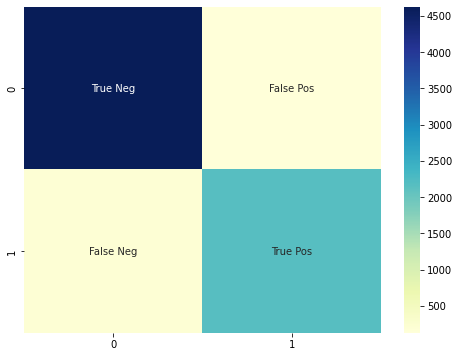

In [144]:
labels = ["True Neg","False Pos","False Neg","True Pos"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(confusion_matrix(y_test, preds2) ,annot = labels,fmt='',cmap = 'YlGnBu');

In [145]:
joblib.dump(rf_model, 'rf_pipeline.pkl')

['rf_pipeline.pkl']